<a href="https://colab.research.google.com/github/MaroonBlue/Speech_Commands_with_RNNs/blob/main/main_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Cloning repository

In [1]:
%cd /content/
!rm -r ./Speech_Commands_with_RNNs/
!git clone https://github.com/MaroonBlue/Speech_Commands_with_RNNs.git
%cd Speech_Commands_with_RNNs/

/content
rm: cannot remove './Speech_Commands_with_RNNs/': No such file or directory
Cloning into 'Speech_Commands_with_RNNs'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 300 (delta 48), reused 60 (delta 30), pack-reused 213
Receiving objects: 100% (300/300), 1.40 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/Speech_Commands_with_RNNs


## Installing packages

In [2]:
!pip install -r requirements.txt
!pip install -U -q tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.8 MB/s eta 0:00:00
  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29623 sha256=0de154589da7641d7d1a0603b3f80c7df10c28c8e1e245f60f93512224384310
  Stored in direc

# Downloading dataset

## Download form URL

In [3]:
!python utils/download_dataset.py

2023-04-25 08:25:21.519358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 08:25:22.464756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1121103842/1121103842 [==============================] - 23s 0us/step
Moved 6798 files to the validation directory
Moved 6835 files to the test directory


## Generate and save training and validation data

In [4]:
!python ./utils/dataset.py

2023-04-25 08:27:30.586839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 08:27:32.049021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Training dataset: 100% 22536/22536 [04:40<00:00, 80.45it/s]
Validation dataset: 100% 6798/6798 [01:08<00:00, 99.90it/s] 


## Copy .npy files to drive

## Copy from local

In [6]:
!cp -R data ../data

In [7]:
!cp -R ../data data

In [8]:
!cp ./saved_data/X_t.npy ../X_t.npy
!cp ./saved_data/y_t.npy ../y_t.npy
!cp ./saved_data/X_v.npy ../X_v.npy
!cp ./saved_data/y_v.npy ../y_v.npy

In [9]:
!cp ../X_t.npy ./saved_data/X_t.npy
!cp ../y_t.npy ./saved_data/y_t.npy
!cp ../X_v.npy ./saved_data/X_v.npy
!cp ../y_v.npy ./saved_data/y_v.npy

# Experiments

## Setup and imports

In [10]:
%cd Speech_Commands_with_RNNs/

[Errno 2] No such file or directory: 'Speech_Commands_with_RNNs/'
/content/Speech_Commands_with_RNNs


In [11]:
import os
import wandb
import tensorflow as tf
import sys
import numpy as np

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from numpy import load

sys.path.append("./")
from utils.utils import set_seeds, make_configs, step_decay
from models.test_model import get_test_model
from models.CNN_LSTM import CNN_LSTM1
from models.GRU import GRU1, GRU2, GRU3
from models.LSTM import LSTM1, LSTM2, LSTM3
from models.simpleRNN import simpleRNN1, simpleRNN2, simpleRNN3

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

## Configs and data

In [12]:
ENTITY = 'wo-team'
PROJECT = 'dl-rnn-audio'
GROUP = 'simple-lstm-gru'
NAME = '_'
SAVE_PATH = 'weights/'

models = {
    'GRU3': GRU3,
}
base_config = {
    'dataloader': {
        'sample_rate': 8000,
        'unknown_silence_samples': 2000,
        'seed': 0,
        'batch_size': 128,
        'convert_to_image': False,
    },
    'training': {
        'n_epochs': 50,
        'dropout': 0.3,
    },
    'compile':{
        'loss': 'sparse_categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy', 'sparse_categorical_accuracy']
    },
    'model': {
        'architecture': 'GRU3',
        'model_init': None,
        'id': None,
        'save_path': None,
    },
    'early_stopper':{
        'monitor': 'val_sparse_categorical_accuracy',
        'min_delta': 0.001,
        'patience': 4,
        'verbose': 1,
        'start_from_epoch': 10,
        'restore_best_weights': True,
    },
    'checkpointer':{
        'monitor': 'val_sparse_categorical_accuracy',
        "verbose": 1,
        'save_best_only': True
    },
    'scheduler': LearningRateScheduler(step_decay),
    'other':{
            'num_classes':12,
    }
}

combinations = {
    'seeds': {
        'dict_path': ['dataloader', 'seed'],
        'values': [0]
    }

}



configs = make_configs(base_config, combinations)

LOAD_PTH = "./saved_data/"
X_t = load(LOAD_PTH + "X_t.npy")
y_t = load(LOAD_PTH + "y_t.npy")
X_v = load(LOAD_PTH + "X_v.npy")
y_v = load(LOAD_PTH + "y_v.npy")
y_t = np.argmax(y_t, axis=1).transpose()
y_v = np.argmax(y_v, axis=1).transpose()

## Training

In [13]:
for i, config in enumerate(configs):

    set_seeds(config['dataloader']['seed'])
    config['model']['id'] = i
    NAME = str(config['model']['id']) + config['model']['architecture'] + "_seed" + str(config['dataloader']['seed']) +"_dropout"+str(config['training']['dropout']).replace(".", ",")
    config['model']['model_init'] = models[config['model']['architecture']]

    wandb.init(
        project = PROJECT,
        entity = ENTITY,
        group = GROUP,
        name = NAME,
        config = config)
    
    l = len(configs)
    print(f"---------------\nConfig {i+1}/{l}\n---------------\n\n")
    print('Running config:', config, "\n")

    input_shape = X_t.shape[1:]

    model = config['model']['model_init'](input_shape=input_shape, output_nodes=12, dropout=config['training']['dropout'])

    model.compile(**config["compile"])
    earlystopper = EarlyStopping(**config["early_stopper"])
    checkpointer = ModelCheckpoint(NAME+'.h5', **config["checkpointer"])
    lrate = config["scheduler"]

    history = model.fit(
                X_t,
                y_t,
                epochs=config['training']['n_epochs'],
                validation_data=(X_v, y_v),
                batch_size=config['dataloader']['batch_size'],
                shuffle=True,
                callbacks=[
                    earlystopper, 
                    checkpointer, 
                    lrate,
                    WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("weights/wandb")
                ])
    save_path = os.path.join(SAVE_PATH, NAME)
    model.save(save_path)

    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


---------------
Config 1/1
---------------


Running config: {'dataloader': {'sample_rate': 8000, 'unknown_silence_samples': 2000, 'seed': 0, 'batch_size': 128, 'convert_to_image': False}, 'training': {'n_epochs': 50, 'dropout': 0.3}, 'compile': {'loss': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy', 'sparse_categorical_accuracy']}, 'model': {'architecture': 'GRU3', 'model_init': <function GRU3 at 0x7f541305c8b0>, 'id': 0, 'save_path': None}, 'early_stopper': {'monitor': 'val_sparse_categorical_accuracy', 'min_delta': 0.001, 'patience': 4, 'verbose': 1, 'start_from_epoch': 10, 'restore_best_weights': True}, 'checkpointer': {'monitor': 'val_sparse_categorical_accuracy', 'verbose': 1, 'save_best_only': True}, 'scheduler': <keras.callbacks.LearningRateScheduler object at 0x7f54130615e0>, 'other': {'num_classes': 12}} 

Changing learning rate to 0.001
Epoch 1/50
159/160 [============================>.] - ETA: 0s - loss: 1.5247 - accuracy: 0.4650 - sparse_ca

wandb: Adding directory to artifact (./weights/wandb)... Done. 0.2s


160/160 [==============================] - 45s 183ms/step - loss: 1.5221 - accuracy: 0.4660 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.6167 - val_accuracy: 0.4639 - val_sparse_categorical_accuracy: 0.4639 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.8030 - sparse_categorical_accuracy: 0.8030
Epoch 2: val_sparse_categorical_accuracy improved from 0.46391 to 0.75917, saving model to 0GRU3_seed0_dropout0,3.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 173ms/step - loss: 0.6293 - accuracy: 0.8030 - sparse_categorical_accuracy: 0.8030 - val_loss: 0.7357 - val_accuracy: 0.7592 - val_sparse_categorical_accuracy: 0.7592 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
159/160 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8702 - sparse_categorical_accuracy: 0.8702
Epoch 3: val_sparse_categorical_accuracy improved from 0.75917 to 0.79175, saving model to 0GRU3_seed0_dropout0,3.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 36s 224ms/step - loss: 0.4255 - accuracy: 0.8702 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.6814 - val_accuracy: 0.7918 - val_sparse_categorical_accuracy: 0.7918 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/50
159/160 [============================>.] - ETA: 0s - loss: 0.3336 - accuracy: 0.8990 - sparse_categorical_accuracy: 0.8990
Epoch 4: val_sparse_categorical_accuracy improved from 0.79175 to 0.84357, saving model to 0GRU3_seed0_dropout0,3.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 172ms/step - loss: 0.3336 - accuracy: 0.8991 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.5213 - val_accuracy: 0.8436 - val_sparse_categorical_accuracy: 0.8436 - lr: 0.0010
Changing learning rate to 0.001
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.9205 - sparse_categorical_accuracy: 0.9205
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.84357


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 173ms/step - loss: 0.2620 - accuracy: 0.9205 - sparse_categorical_accuracy: 0.9205 - val_loss: 0.6543 - val_accuracy: 0.8219 - val_sparse_categorical_accuracy: 0.8219 - lr: 0.0010
Changing learning rate to 0.001
Epoch 6/50
159/160 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9298 - sparse_categorical_accuracy: 0.9298
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.84357


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 27s 171ms/step - loss: 0.2371 - accuracy: 0.9298 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.6387 - val_accuracy: 0.8152 - val_sparse_categorical_accuracy: 0.8152 - lr: 0.0010
Changing learning rate to 0.001
Epoch 7/50
159/160 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9416 - sparse_categorical_accuracy: 0.9416
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.84357


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 173ms/step - loss: 0.2001 - accuracy: 0.9416 - sparse_categorical_accuracy: 0.9416 - val_loss: 0.7053 - val_accuracy: 0.8146 - val_sparse_categorical_accuracy: 0.8146 - lr: 0.0010
Changing learning rate to 0.001
Epoch 8/50
159/160 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9497 - sparse_categorical_accuracy: 0.9497
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.84357


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 173ms/step - loss: 0.1695 - accuracy: 0.9495 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.8942 - val_accuracy: 0.7939 - val_sparse_categorical_accuracy: 0.7939 - lr: 0.0010
Changing learning rate to 0.001
Epoch 9/50
159/160 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9534 - sparse_categorical_accuracy: 0.9534
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.84357


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.1582 - accuracy: 0.9534 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.6525 - val_accuracy: 0.8333 - val_sparse_categorical_accuracy: 0.8333 - lr: 0.0010
Changing learning rate to 0.0004
Epoch 10/50
159/160 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9766 - sparse_categorical_accuracy: 0.9766
Epoch 10: val_sparse_categorical_accuracy improved from 0.84357 to 0.88121, saving model to 0GRU3_seed0_dropout0,3.h5


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 30s 186ms/step - loss: 0.0799 - accuracy: 0.9766 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.5214 - val_accuracy: 0.8812 - val_sparse_categorical_accuracy: 0.8812 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 11/50
159/160 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9845 - sparse_categorical_accuracy: 0.9845
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.0545 - accuracy: 0.9846 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.6052 - val_accuracy: 0.8723 - val_sparse_categorical_accuracy: 0.8723 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 12/50
159/160 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 173ms/step - loss: 0.0454 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.6258 - val_accuracy: 0.8708 - val_sparse_categorical_accuracy: 0.8708 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9890 - sparse_categorical_accuracy: 0.9890
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 174ms/step - loss: 0.0395 - accuracy: 0.9890 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.7130 - val_accuracy: 0.8737 - val_sparse_categorical_accuracy: 0.8737 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 14/50
159/160 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9878 - sparse_categorical_accuracy: 0.9878
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 27s 170ms/step - loss: 0.0424 - accuracy: 0.9878 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.8998 - val_accuracy: 0.8426 - val_sparse_categorical_accuracy: 0.8426 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 15/50
159/160 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9857 - sparse_categorical_accuracy: 0.9857
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 177ms/step - loss: 0.0473 - accuracy: 0.9857 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.7644 - val_accuracy: 0.8680 - val_sparse_categorical_accuracy: 0.8680 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 16/50
159/160 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9868 - sparse_categorical_accuracy: 0.9868
Epoch 16: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 175ms/step - loss: 0.0465 - accuracy: 0.9868 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.8075 - val_accuracy: 0.8612 - val_sparse_categorical_accuracy: 0.8612 - lr: 4.0000e-04
Changing learning rate to 0.0004
Epoch 17/50
159/160 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9872 - sparse_categorical_accuracy: 0.9872Restoring model weights from the end of the best epoch: 13.

Epoch 17: val_sparse_categorical_accuracy did not improve from 0.88121


wandb: Adding directory to artifact (./weights/wandb)... Done. 0.1s


160/160 [==============================] - 28s 178ms/step - loss: 0.0427 - accuracy: 0.9872 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.9051 - val_accuracy: 0.8467 - val_sparse_categorical_accuracy: 0.8467 - lr: 4.0000e-04
Epoch 17: early stopping


batch/accuracy,▁▂▃▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,█████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▂▃▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/accuracy,▁▆▆▇▇▇▇▇█████████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,█████████▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/lr,█████████▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▆▇▇▇▇▇█████████


# KAGGLE 

In [36]:
from utils.dataset import make_test_dataset
X_test, y_test = make_test_dataset()

SAVE_PTH = "./saved_data/"
np.save(SAVE_PTH + "X_test.npy", X_test)
np.save(SAVE_PTH + "y_test.npy", y_test)

Test dataset: 100%|██████████| 6835/6835 [01:26<00:00, 79.08it/s] 


In [22]:
best_model = tf.keras.models.load_model('0GRU3_seed0_dropout0,3.h5')

In [37]:
y_test = np.argmax(y_test, axis=1).transpose()

In [52]:
pred_label = best_model.predict(X_v)
pred_label = np.argmax(pred_label, axis=1).transpose()
pred_label

192/192 [==============================] - 2s 11ms/step


array([10,  2, 10, ..., 10, 10, 10])

In [53]:
y_v.shape

(6137,)

In [54]:
y_test.shape

(6231,)

In [55]:
pred_label.shape

(6137,)

In [56]:
accuracy = np.mean(y_v == pred_label)
accuracy

0.8812123187225028

In [ ]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown', 'silence']    
label_value = target_list
label_value.append('unknown')
label_value.append('silence')
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [58]:
import pandas as pd

In [93]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown', 'silence']

In [79]:
classes[y_v[1]]

'up'

In [75]:
classes[y_v]

TypeError: ignored

In [61]:
pd.crosstab(classes[np.argmax(y_v,1)], classes[np.argmax(pred_label,1)], colnames=['prediction'], rownames=['truth'])

AxisError: ignored

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_v, pred_label)

array([[ 213,    2,    0,    1,    2,    1,    1,    0,    0,    2,    9,
           1],
       [   6,  211,    1,    1,    0,    0,    0,    1,    0,   11,    4,
           0],
       [   0,    0,  191,    0,    1,    1,    3,   12,    2,    3,    8,
           0],
       [   2,    6,    0,  229,    0,    0,    1,    1,    3,    3,    2,
           0],
       [  21,    0,    0,    0,  205,    1,    0,    1,    0,    2,    3,
           0],
       [   0,    0,    2,    0,    7,  217,    1,    0,    0,    0,    8,
           0],
       [   0,    2,    2,    0,    0,    2,  221,    3,    1,    1,    0,
           2],
       [   0,    0,    6,    0,    0,    0,    4,  214,    1,    3,    4,
           0],
       [   0,    2,    5,    1,    3,    0,    0,    4,  205,    0,    5,
           0],
       [   0,   12,    1,    4,    0,    2,    2,    4,    1,  193,   10,
           2],
       [  51,   34,   28,   34,   58,   61,   92,   22,   43,   70, 3309,
          10],
       [   0,    0,  

In [94]:
classes_words_v = []
for i in range(len(y_v)):
  classes_words_v.append(classes[y_v[i]])

In [103]:
len(y_v)

6137

In [101]:
len(classes_words_v)

6137

In [95]:
classes_words_pred = []
for i in range(len(pred_label)):
  classes_words_pred.append(classes[pred_label[i]])

In [104]:
len(pred_label)

6137

In [102]:
len(classes_words_pred)

6137

In [119]:
df = pd.crosstab(y_v, pred_label, colnames=['prediction'], rownames = ['truth'])
df.columns = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown', 'silence']
df.index = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown']
df

,yes,no,up,down,left,right,on,off,stop,go,uknown,silence
yes,213,2,0,1,2,1,1,0,0,2,9,1
no,6,211,1,1,0,0,0,1,0,11,4,0
up,0,0,191,0,1,1,3,12,2,3,8,0
down,2,6,0,229,0,0,1,1,3,3,2,0
left,21,0,0,0,205,1,0,1,0,2,3,0
right,0,0,2,0,7,217,1,0,0,0,8,0
on,0,2,2,0,0,2,221,3,1,1,0,2
off,0,0,6,0,0,0,4,214,1,3,4,0
stop,0,2,5,1,3,0,0,4,205,0,5,0
go,0,12,1,4,0,2,2,4,1,193,10,2


In [113]:
from seaborn import heatmap

In [148]:
df1 =df.iloc[:,:-1]
#np.matrix(df1)-np.dot(np.diag(np.matrix(df1)),np.identity(11))
df2 = pd.DataFrame(np.matrix(df1)-np.diag(np.diag(np.matrix(df1))))
df2.columns = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown']
df2.index = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'uknown']
df2['silence'] = df.iloc[:,-1]


In [149]:
df2

,yes,no,up,down,left,right,on,off,stop,go,uknown,silence
yes,0,2,0,1,2,1,1,0,0,2,9,1
no,6,0,1,1,0,0,0,1,0,11,4,0
up,0,0,0,0,1,1,3,12,2,3,8,0
down,2,6,0,0,0,0,1,1,3,3,2,0
left,21,0,0,0,0,1,0,1,0,2,3,0
right,0,0,2,0,7,0,1,0,0,0,8,0
on,0,2,2,0,0,2,0,3,1,1,0,2
off,0,0,6,0,0,0,4,0,1,3,4,0
stop,0,2,5,1,3,0,0,4,0,0,5,0
go,0,12,1,4,0,2,2,4,1,0,10,2


<Axes: >

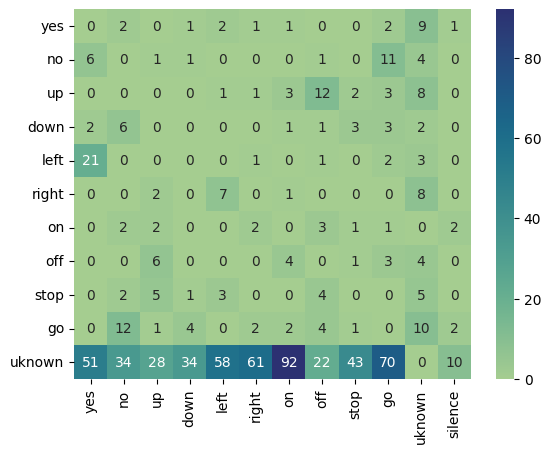

In [151]:
heatmap(df2, cmap="crest", annot=True)